# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)    
add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
add_path('/home/jjian03/iconference_followup_study')


### Load Data

In [2]:
from lib.Repository import *
from lib.Utility import *
from lib.modeling import *
from lib.preprocessing import *
from lib.preprocessing.HTMLParser import html_parser
from lib.viz import *

Allocated 16 CPUs


In [3]:
import time, datetime, os
start_time = time.time()
cache_file_path_abs = os.path.join('..', 'data')
cache_file_path_abs = os.path.join(cache_file_path_abs, 'untrunc_data_cleaned_url.csv')
cache_file_path_abs = os.path.abspath(cache_file_path_abs)
raw_data = pd.read_csv(cache_file_path_abs)

raw_data = raw_data.drop(['first_appear', 'url'], axis=1).iloc[:, 1:]
raw_data.info()

print(f'raw_data: {shape(raw_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58910 entries, 0 to 58909
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58910 non-null  float64
 1   has_www                                 58910 non-null  float64
 2   has_iframe                              58910 non-null  float64
 3   int                                     58910 non-null  float64
 4   org                                     58910 non-null  float64
 5   gov                                     58910 non-null  float64
 6   in                                      58910 non-null  float64
 7   eu                                      58910 non-null  float64
 8   cn                                      58910 non-null  float64
 9   kr                                      58910 non-null  float64
 10  url_depth                               58910 non-null  fl

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
start_time = time.time()

training_rate=.7
train_data, test_data = train_test_split(raw_data, test_size=1-training_rate, random_state=seed)


print('Shape of the dataframe:')
print(f'train_data: {shape(train_data)}')
print(f'test_data: {len(test_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

Shape of the dataframe:
train_data: (41236, 40)
test_data: 17674
--- 00 minutes, 0.02 seconds ---


## Feature Engineering

### Build Pipeline

In [5]:
display(pd.DataFrame({
    'unique count': print_unique_count(train_data),
    'na count': print_na_count(train_data)
}, index=train_data.columns))

,unique count,na count
protocol_type,2,0
has_www,2,0
has_iframe,2,0
int,2,0
org,2,0
gov,2,0
in,2,0
eu,2,0
cn,2,0
kr,2,0


## Modeling

### Elastic Net Regression

#### Model - 1st Edition

In [6]:
X_train = train_data
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)

Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_l

In [7]:
import numpy as np
from sklearn.linear_model import ElasticNet


start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 01 minutes, 52.14 seconds ---


In [8]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [9]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


The residual is approximately normal distributed. But the shape of the residual-prediction scatter plot shows that the data space might not linear correlated with the dependent variable (which agrees with the r^2 score). 

##### EDA

- Scatter distribution on each features

In [10]:
# Visualizer.plot_scatter_distribution(X_train, y_train, 'Training Set Scatter Plot')


In [11]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 52.14 seconds ---


In [12]:
def build_visualization_matrix(result_train, result_test):
    performance_matrix_train = pd.DataFrame()
    performance_matrix_train['alpha'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_train['mse'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_train['r_2'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_train[col_name] = pd.Series(result_train.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_train['type'] = 'Train'

    performance_matrix_test = pd.DataFrame()
    performance_matrix_test['alpha'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_test['mse'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_test['r_2'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_test[col_name] = pd.Series(result_test.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_test['type'] = 'Test'

    performance_matrix = pd.DataFrame()
    performance_matrix = performance_matrix.append(performance_matrix_train)
    performance_matrix = performance_matrix.append(performance_matrix_test)

    return performance_matrix

performance_matrix = build_visualization_matrix(result_train, result_test)

In [13]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [14]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

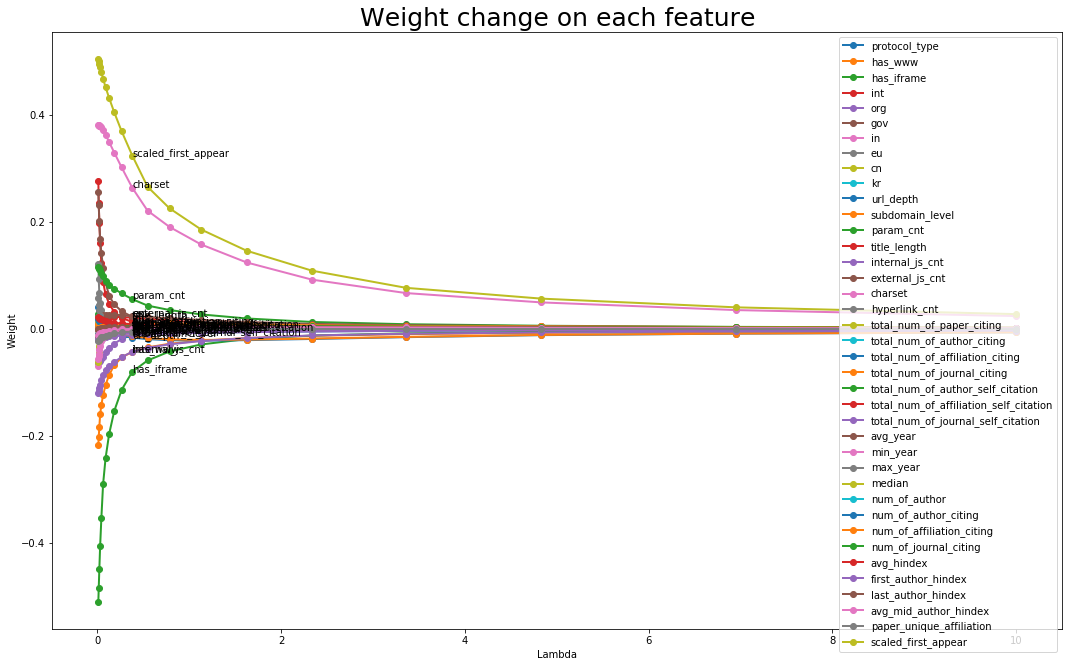

In [15]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

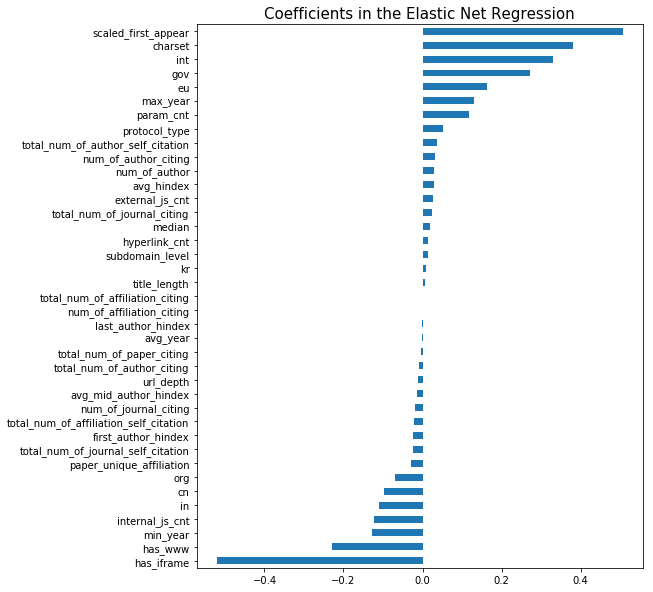

In [16]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### Model - 2nd Edition

##### Try encode the suffix index label with logarithm

In [17]:
X_train = train_data
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)

Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_l

In [18]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 01 minutes, 54.20 seconds ---


In [19]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [20]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


In [21]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 52.89 seconds ---


In [22]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [23]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [24]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

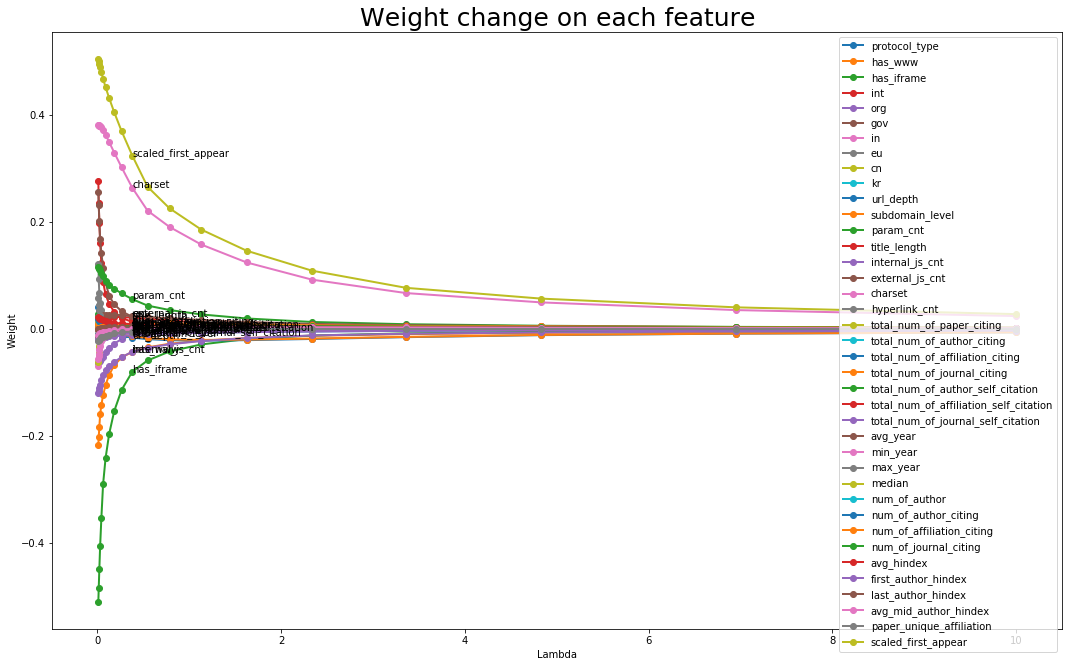

In [25]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

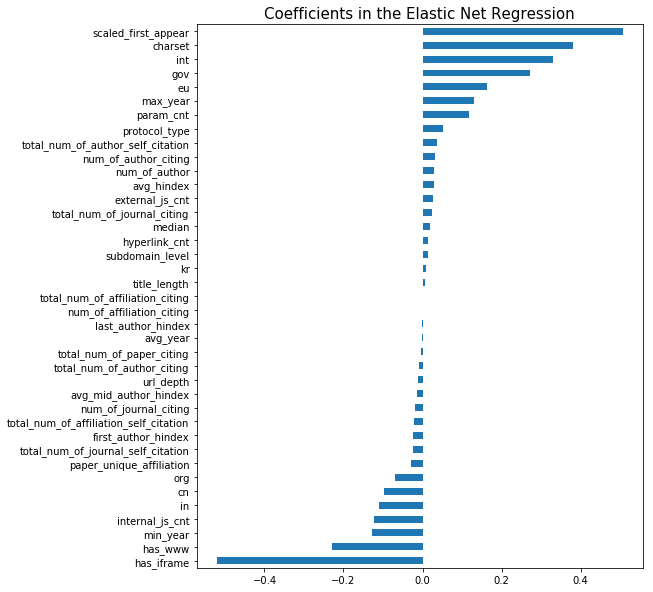

In [26]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### Model - 3rd Edition

##### Try Tong's methd

In [27]:
X_train = train_data
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)

Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_l

In [28]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 02 minutes, 14.76 seconds ---


In [29]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [30]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


In [31]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 54.89 seconds ---


In [32]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [33]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [34]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

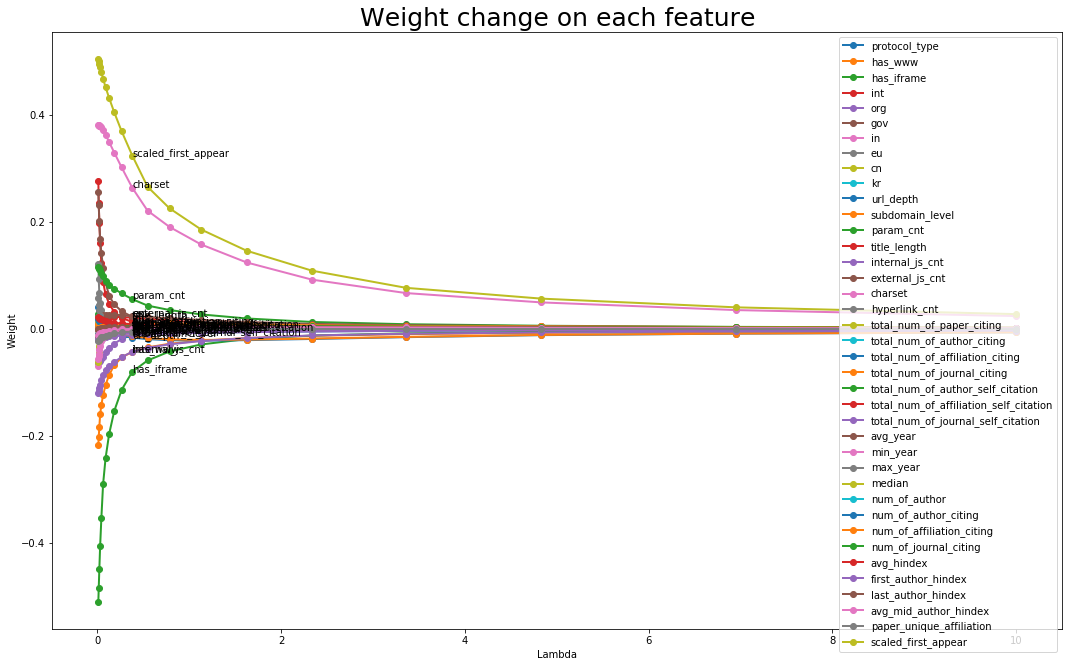

In [35]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

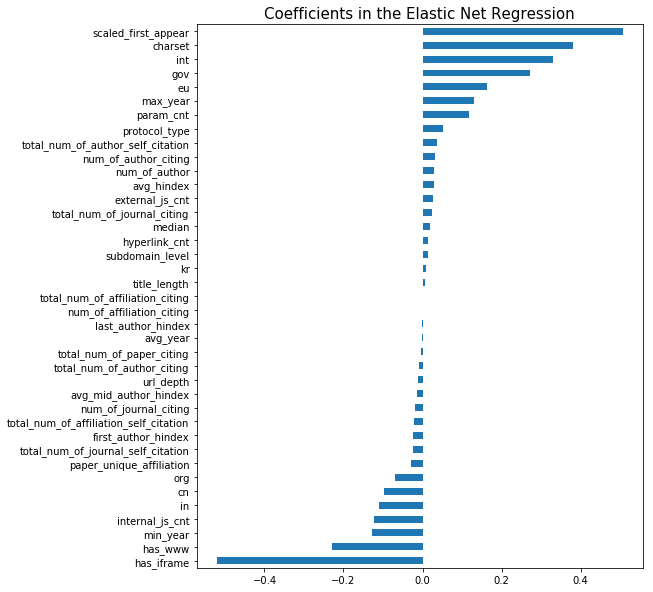

In [36]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### Model - 4th Edition - Extract More Features

##### Features in source code

- Restore the test data

In [37]:
# First round pipeline


result = train_data
print(type(result))


<class 'pandas.core.frame.DataFrame'>


- Consolidate the pipeline

In [38]:
result = train_data

result[[
    'title_length',
    'internal_js_cnt',
    'external_js_cnt',
    'charset',
    'has_iframe',
    'hyperlink_cnt']].head()

,title_length,internal_js_cnt,external_js_cnt,charset,has_iframe,hyperlink_cnt
40463,-0.060595,-0.219093,-0.390278,0.852271,0.0,0.176433
50057,-0.356487,0.282505,2.108818,0.852271,1.0,0.034520
47712,0.787627,0.784103,-0.198040,-1.108308,1.0,0.094439
14247,-0.514296,0.951303,-0.005802,0.852271,1.0,-0.075856
25415,0.590366,0.282505,1.532104,0.852271,0.0,-0.019091


In [39]:
X_train = train_data
y_train = X_train.label
print(X_train.columns)
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)


train = X_train.copy()
train.loc[:,'label'] = y_train
test = X_test.copy()
test.loc[:,'label'] = y_test


Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear', 'label'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
      

In [40]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 01 minutes, 54.07 seconds ---


In [41]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [42]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


In [43]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 51.94 seconds ---


In [44]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [45]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [46]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

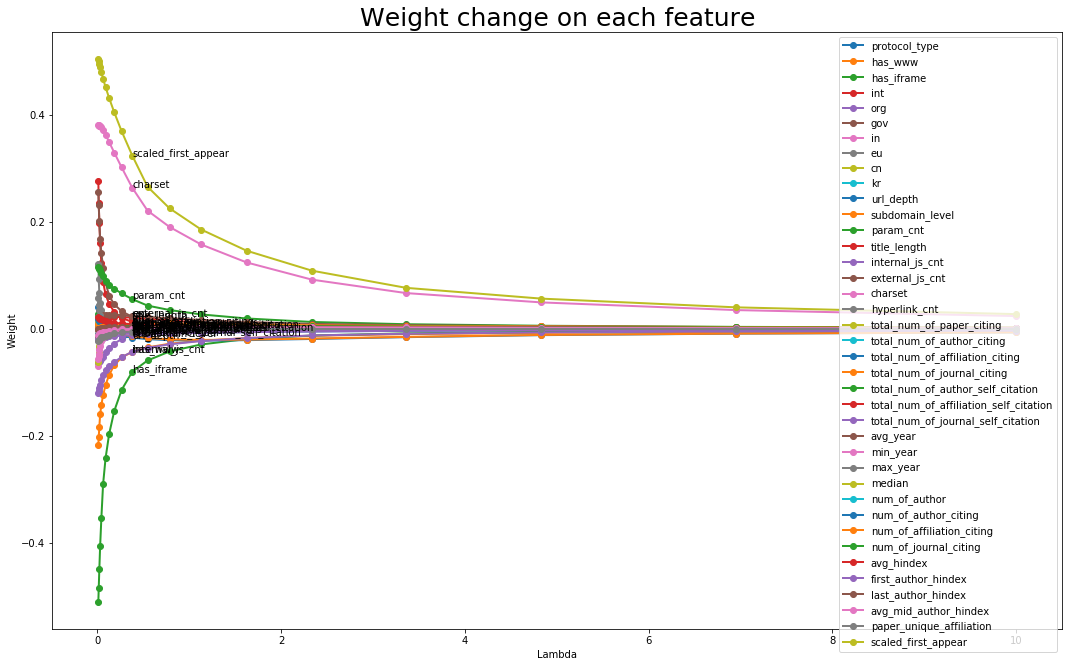

In [47]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

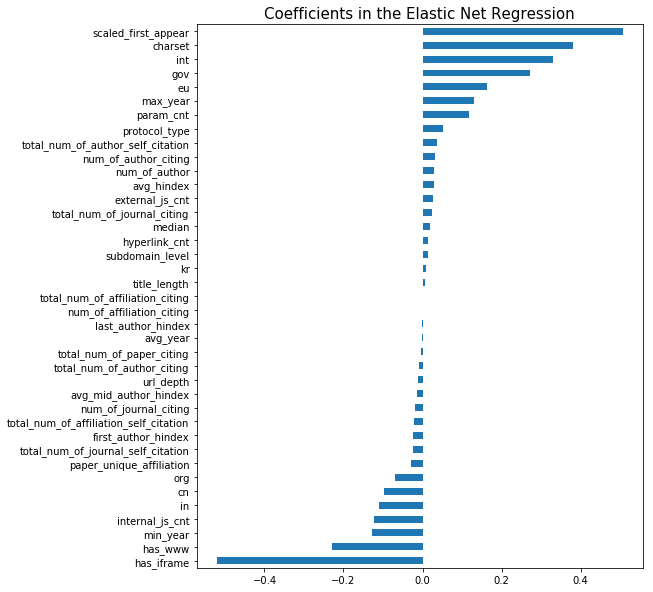

In [48]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### Model - 5th Edition - Add Features From MAG

In [49]:
X_train = train_data
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)


train = X_train.copy()
train.loc[:,'label'] = y_train
test = X_test.copy()
test.loc[:,'label'] = y_test


Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_l

In [50]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 01 minutes, 55.59 seconds ---


In [51]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [52]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


In [53]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 52.27 seconds ---


In [54]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [55]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [56]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

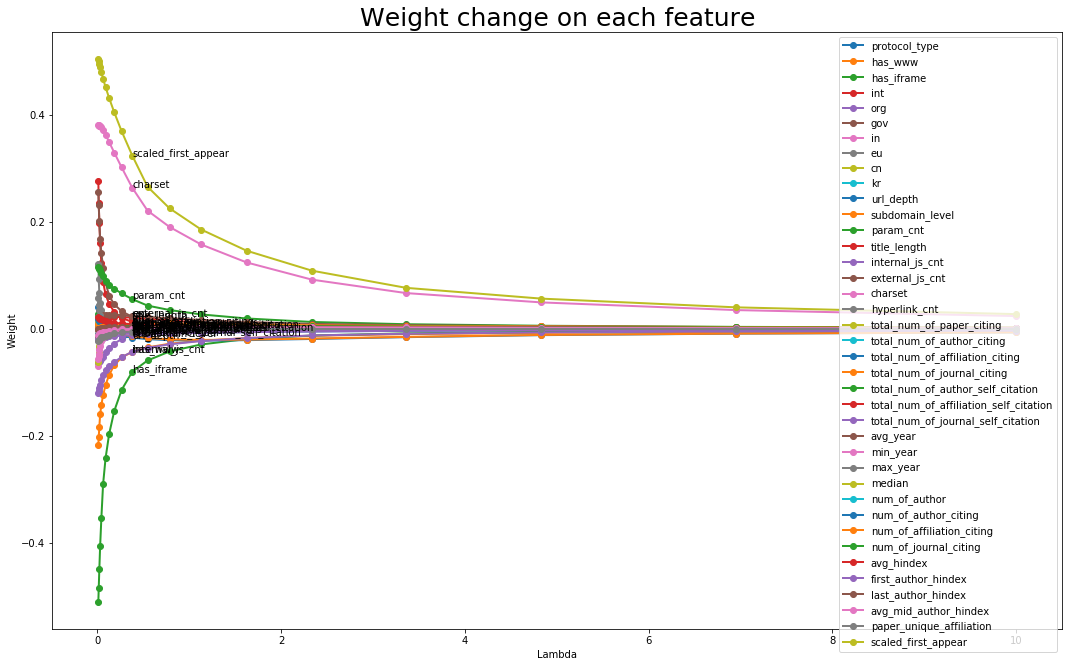

In [57]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

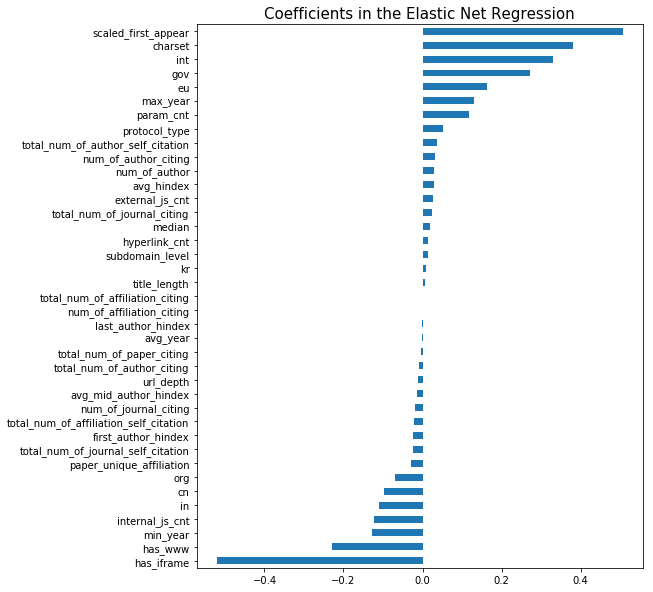

In [58]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### 6th Edition - Combine suffix dummy with MAG

In [59]:
df = raw_data
df.to_csv('wq.csv')
df.info()
print('Finished. ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58910 entries, 0 to 58909
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58910 non-null  float64
 1   has_www                                 58910 non-null  float64
 2   has_iframe                              58910 non-null  float64
 3   int                                     58910 non-null  float64
 4   org                                     58910 non-null  float64
 5   gov                                     58910 non-null  float64
 6   in                                      58910 non-null  float64
 7   eu                                      58910 non-null  float64
 8   cn                                      58910 non-null  float64
 9   kr                                      58910 non-null  float64
 10  url_depth                               58910 non-null  fl

In [60]:
X_train = train_data
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = test_data
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)


train = X_train.copy()
train.loc[:,'label'] = y_train
test = X_test.copy()
test.loc[:,'label'] = y_test


Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_l

In [61]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 14.56%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.036,832.442,0.000
scaled_first_appear,0.5067,0.010,49.598,0.000
charset,0.3805,0.010,37.130,0.000
int,0.3302,0.056,5.938,0.000
gov,0.2733,0.031,8.785,0.000
eu,0.1627,0.081,2.022,0.043
max_year,0.1297,0.713,0.182,0.856
param_cnt,0.1165,0.009,12.562,0.000
protocol_type,0.0520,0.027,1.904,0.057
total_num_of_author_self_citation,0.0360,0.016,2.197,0.028



R^2 on Testing Set: 13.89%


,Coefficients,Standard Errors,t values,Probabilities
Constant,29.9455,0.053,560.352,0.000
scaled_first_appear,0.5067,0.015,33.174,0.000
charset,0.3805,0.015,24.628,0.000
int,0.3302,0.086,3.826,0.000
gov,0.2733,0.046,5.964,0.000
eu,0.1627,0.120,1.357,0.175
max_year,0.1297,1.008,0.129,0.898
param_cnt,0.1165,0.014,8.369,0.000
protocol_type,0.0520,0.041,1.272,0.203
total_num_of_author_self_citation,0.0360,0.024,1.475,0.140


--- 01 minutes, 54.97 seconds ---


In [62]:
# Visualizer.plot_distribution(pd.DataFrame({
#     'residual': result_train.best_result.residual
# }), "Residual Distribution", height=400)


In [63]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

# Visualizer.plot_residual(residual_df)


In [64]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 01 minutes, 51.75 seconds ---


In [65]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [66]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [67]:
# Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

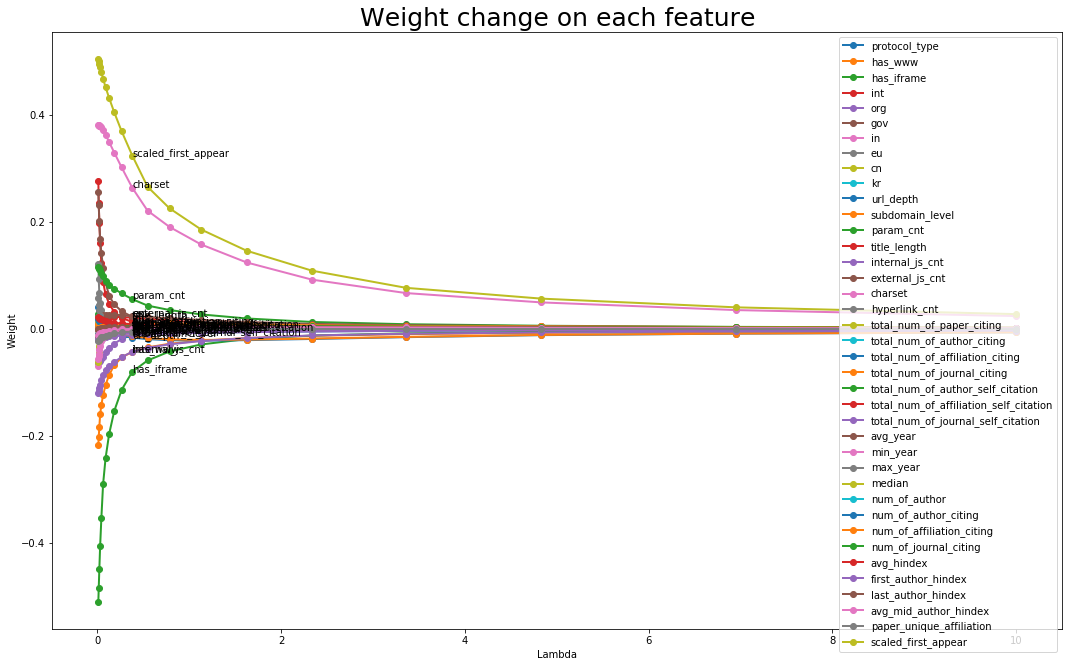

In [68]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

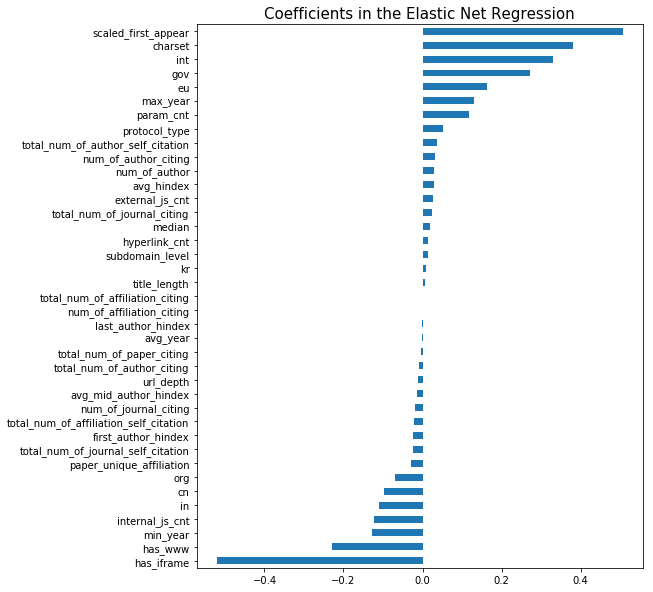

In [69]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")